<a href="https://colab.research.google.com/github/ArtuRUA01/DCGAN-human-face/blob/main/GAN_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


!kaggle datasets download -d jessicali9530/celeba-dataset  -p /content
!unzip celeba-dataset.zip
!cd ~/.kaggle
!rm list_attr_celeba.csv
!rm list_bbox_celeba.csv
!rm list_eval_partition.csv
!rm list_landmarks_align_celeba.csv

In [ ]:
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image
import time

import tensorflow as tf
from tensorflow import keras
import random
import pandas as pd

In [ ]:
class GAN():

    def __init__(self):

        self.IMG_WIDTH = 128
        self.IMG_HEIGHT = 128
        self.IMG_CHANNELS = 3
        self.IMG_SHAPE = (self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS)
        self.ORI_IMG_WIDTH = 178
        self.ORI_IMG_HEIGHT = 208
        self.LATENT_DIM = 32

        self.RESULT_DIR = 'results_face_img'
        self.LOSS_DIR = 'loss'
        self.IMG_PATH = '/img_{}.png'
        for i in [self.RESULT_DIR, self.LOSS_DIR]:
            if not os.path.isdir(i):
                os.mkdir(i)

        # Define Generator and Discriminator
        self.generator = self.define_generator()
        self.discriminator = self.define_discriminator()
        self.discriminator.trainable = False

        # Define GAN
        self.gan = self.define_gan()
        optimizer = keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
        self.gan.compile(optimizer=optimizer, loss='binary_crossentropy')


    def resize_img(self):
        diff = (self.ORI_IMG_HEIGHT - self.ORI_IMG_WIDTH) // 2
        rectangular_region = (0, diff, self.ORI_IMG_WIDTH, self.ORI_IMG_HEIGHT - diff)

        images = []
        for ori_img in os.listdir("img_align_celeba/img_align_celeba/")[:5000]:
            img = Image.open("img_align_celeba/img_align_celeba/" + ori_img).crop(rectangular_region)
            img.thumbnail((self.IMG_WIDTH, self.IMG_HEIGHT), Image.ANTIALIAS)
            images.append(np.uint8(img))

        images = np.array(images) / 255
        return images

    def random_img(self):
        plt.figure(1, figsize=(10, 10))
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(self.images[random.randint(0, 5000)])
            plt.axis('off')
        plt.show()

    def define_generator(self):

        noise_shape = (self.LATENT_DIM, )
        model = keras.models.Sequential()

        model.add(keras.layers.Dense(128 * 16 * 16, input_shape = noise_shape))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Reshape((16, 16, 128)))
        model.add(keras.layers.Conv2D(256, 5, padding='same'))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same'))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same'))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same'))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2D(512, 5, padding='same'))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2D(512, 5, padding='same'))
        model.add(keras.layers.Conv2D(self.IMG_CHANNELS, 7, activation='tanh', padding='same'))

        noise = keras.layers.Input(shape = noise_shape)
        gen_img = model(noise)

        generator =  keras.models.Model(noise, gen_img, name = "Generator")
        
        return generator

    def define_discriminator(self):

        model = keras.models.Sequential()

        model.add(keras.layers.Conv2D(256, 3, input_shape = self.IMG_SHAPE))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2D(256, 4, strides=2))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2D(256, 4, strides=2))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2D(256, 4, strides=2))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Conv2D(256, 4, strides=2))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dropout(0.4))
        model.add(keras.layers.Dense(1, activation='sigmoid'))

        img_input = keras.layers.Input(shape=self.IMG_SHAPE)
        decision = model(img_input)

        discriminator = keras.models.Model(img_input, decision, name = "Discriminator")

        optimizer = keras.optimizers.RMSprop(
            lr=.0001,
            clipvalue=1.0,
            decay=1e-8
        )

        discriminator.compile(
            optimizer=optimizer,
            loss='binary_crossentropy'
        )

        return discriminator

    def define_gan(self):
        gan_input = keras.layers.Input(shape=(self.LATENT_DIM, ))
        gan_output = self.discriminator(self.generator(gan_input))
        gan = keras.models.Model(gan_input, gan_output, name = 'GAN')

        return gan


    def save_model(self, epoch):
        self.gan.save_weights('gan_{}.h5'.format(epoch+1))
    
    
    def write_to_txt(self, filename, number):
        f = open(f"{filename}.txt", "a")
        f.write(str(number) + '\n')
        f.close()


    def summarize_performance(self, d_loss, gan_loss, epoch):
        print('d_loss: %.4f,  gan_loss: %.4f.' % (d_loss, gan_loss))
        latent_vectors = np.random.normal(size=(1, self.LATENT_DIM)) / 2
        generated = self.generator.predict(latent_vectors)
        plt.imshow(generated[0])
        plt.savefig(os.path.join(self.RESULT_DIR + self.IMG_PATH.format(epoch+1)))


    def plot_loss(self):

        gan_loss = pd.read_csv('loss/d_loss.txt', sep = ' ', header = None, names = ['loss'])
        d_loss = pd.read_csv('loss/gan_loss.txt', sep = ' ', header = None, names = ['loss'])

        plt.figure(figsize=(15, 9))
        gan_loss['loss'].plot()
        d_loss['loss'].plot()
        plt.grid(True)
        plt.xlabel('Epochs', size = 18)
        plt.ylabel('Loss', size = 18)
        plt.title('Discriminator loss function', size = 20)

        plt.savefig(f'loss/loss.png')


    def train(self, epochs=20000, batch_size=16):

        for epoch in range(epochs):

        ### Discriminator

            gen_input = np.random.normal(size=(batch_size, self.LATENT_DIM)) / 2
            gen_data = self.generator.predict(gen_input)

            idx = np.random.randint(0, self.images.shape[0], batch_size)
            real_data = self.images[idx]
            combined_data = np.concatenate([gen_data, real_data])
    
            valid_data = np.concatenate([np.zeros((batch_size, 1)), np.ones((batch_size, 1))])

            d_loss = self.discriminator.train_on_batch(combined_data, valid_data)

        ### Generative Adversarial Net (GAN)

            gen_input = np.random.normal(size=(batch_size, self.LATENT_DIM)) / 2
            valid_data = np.ones((batch_size, 1))

            gan_loss = self.gan.train_on_batch(gen_input, valid_data)

            if epoch % 50 == 49:
                self.summarize_performance(d_loss, gan_loss, epoch)
                self.write_to_txt("loss/d_loss", d_loss)
                self.write_to_txt("loss/gan_loss", gan_loss)
                




In [ ]:
gan_class = GAN()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


9 random resize images


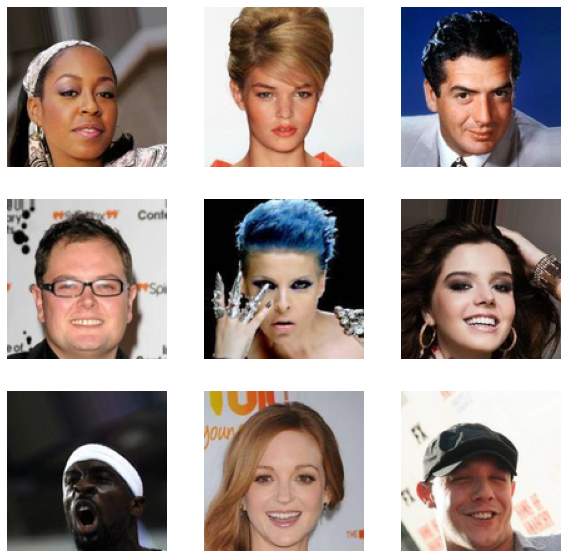

In [ ]:

#Prepare images
gan_class.images = gan_class.resize_img()
print(f'9 random resize images')
gan_class.random_img()

d_loss: 0.5942,  gan_loss: 0.7097.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d_loss: 0.6991,  gan_loss: 0.6662.
d_loss: 0.5997,  gan_loss: 0.7557.


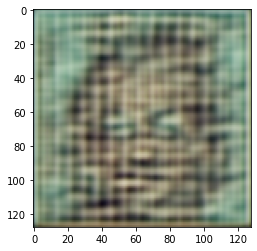

In [ ]:
gan_class.train(150)

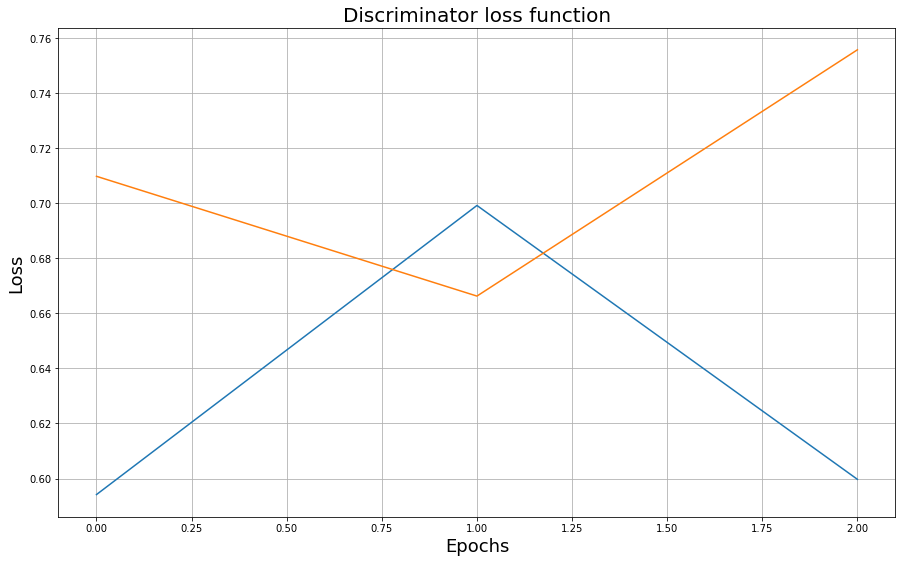

In [ ]:
gan_class.plot_loss()

In [ ]:
del gan_class

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


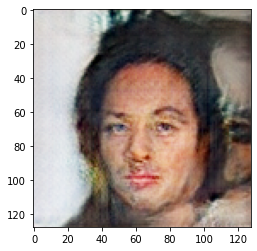

In [ ]:
gan_class = GAN()
gan_class.gan.load_weights('gan_15000.h5')
img = gan_class.generator.predict(np.random.normal(size=(1, 32))/2)
plt.imshow(img[0])